In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns

from bayesian_statistics.utils_2 import *


## データの生成

In [7]:
# 真のパラメータ
beta_true = np.array([-2, 0, 0, 5, -5])  
lambda_star_true = 40  

# 計画行列
def create_complex_design_matrix(t, omega=np.pi / 5):
    return np.vstack([
        np.ones_like(t),
        t,
        t**2,
        np.sin(omega * t),
        np.cos(omega * t)
    ]).T

# 真の強度関数
true_intensity_func = IntensityFunction(
    design_matrix_func=create_complex_design_matrix,
    beta=beta_true,
    lambda_star=lambda_star_true
)

# 観測データの生成
T = 20.0
region = [(0, T)]  
W_obs, y_obs, t_obs = generate_IPP(region, true_intensity_func, generate_U_flag=False)

t1 = t_obs[y_obs == 1]
t0 = t_obs[y_obs == 0]
plot_events(t0, t1, T, true_intensity_func)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 500)

In [3]:
# 事前分布のハイパーパラメータ
prior_beta_mean = np.zeros(len(beta_true))
prior_beta_cov = np.eye(len(beta_true)) * 10
prior_lambda_shape = 2.0
prior_lambda_rate = 1.0

# ギブスサンプラーの実行
num_iterations = 20000
intensity_func = IntensityFunction(
    design_matrix_func=create_complex_design_matrix, 
    beta=np.zeros(len(beta_true)), 
    lambda_star=1.0
)

beta_samples, lambda_star_samples = mcmc_sampler(
    T=T,
    intensity_func=intensity_func,
    t_obs=t_obs,
    y_obs=y_obs,
    num_iterations=num_iterations,
    prior_beta_mean=prior_beta_mean,
    prior_beta_cov=prior_beta_cov,
    prior_lambda_shape=prior_lambda_shape,
    prior_lambda_rate=prior_lambda_rate
)

burn_in = 500  
beta_samples = np.array(beta_samples)[burn_in:, :]
lambda_star_samples = np.array(lambda_star_samples)[burn_in:]

100%|██████████| 20000/20000 [00:40<00:00, 490.78it/s]


/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(beta_samples[:, i], shade=True, color='blue')
/home/ohta/dev/bayesian_statistics/bayesian_statistics/utils.py:245: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill

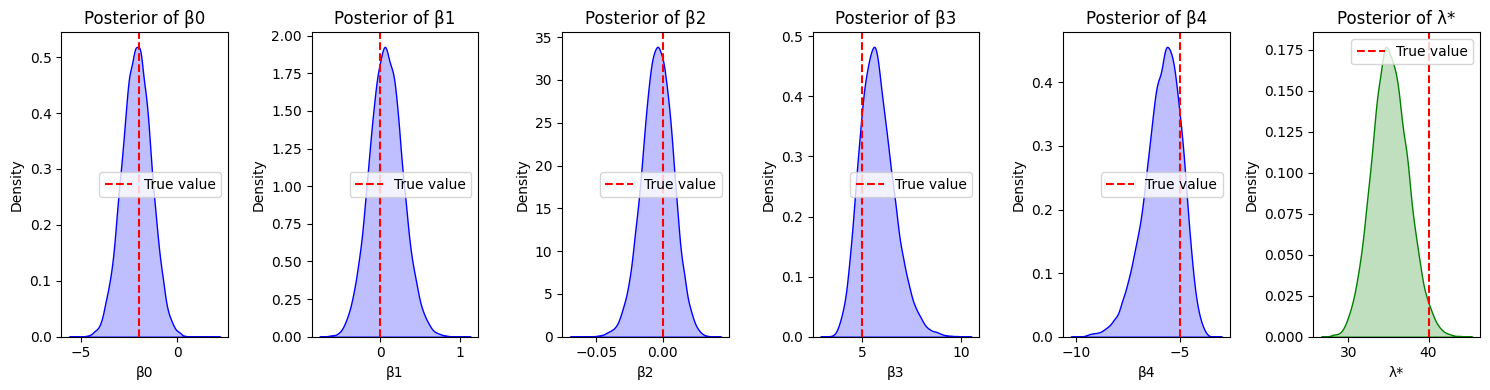

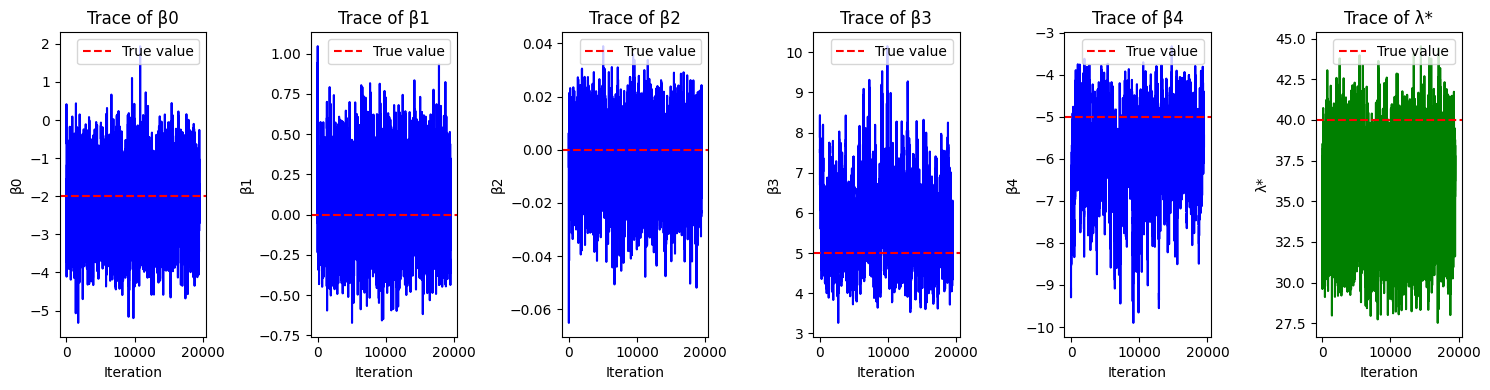

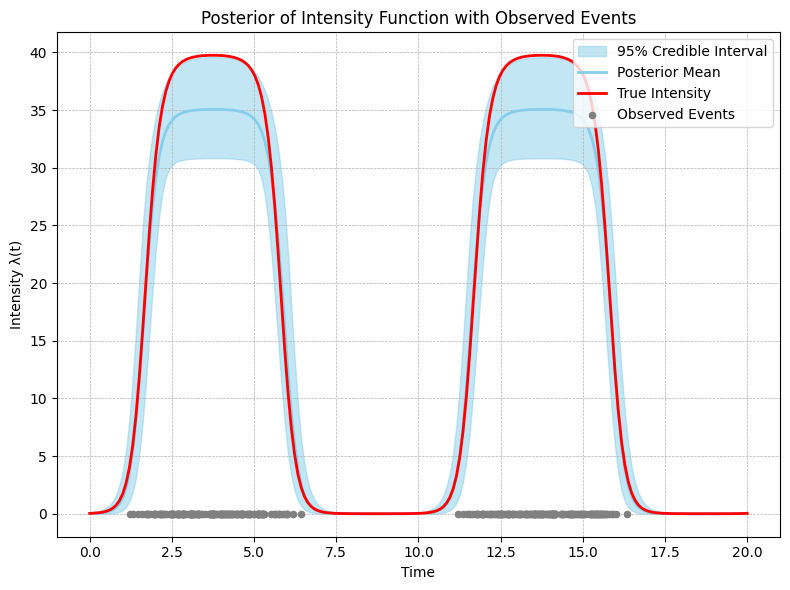

In [4]:
# 各種プロット

plot_posterior_distributions(
    beta_samples=np.array(beta_samples), 
    lambda_star_samples=np.array(lambda_star_samples),
    true_beta=beta_true,  
    true_lambda_star=lambda_star_true  
)

plot_trace_plots(
    beta_samples=beta_samples, 
    lambda_star_samples=lambda_star_samples,
    true_beta=beta_true,
    true_lambda_star=lambda_star_true
)

plot_intensity_posterior_with_events(
    beta_samples=np.array(beta_samples),
    lambda_star_samples=np.array(lambda_star_samples),
    intensity_func=intensity_func,
    T=T,
    events=t_obs[y_obs == 1] ,
    num_points=200,
    credible_interval=0.95,
    true_intensity_func=lambda t:true_intensity_func.lambda_func(t)  
)


In [7]:
import arviz as az

# サンプル数とパラメータ数の取得
num_samples, num_beta = beta_samples.shape

# パラメータ名とサンプルの辞書を作成
posterior_samples = {}

# βの各成分を辞書に追加
for i in range(num_beta):
    param_name = f'beta_{i}'
    posterior_samples[param_name] = beta_samples[:, i]

# λ*を辞書に追加
posterior_samples['lambda_star'] = lambda_star_samples

# InferenceDataオブジェクトを作成
idata = az.from_dict(posterior=posterior_samples)



In [8]:
idata

Inference data with groups:
	> posterior

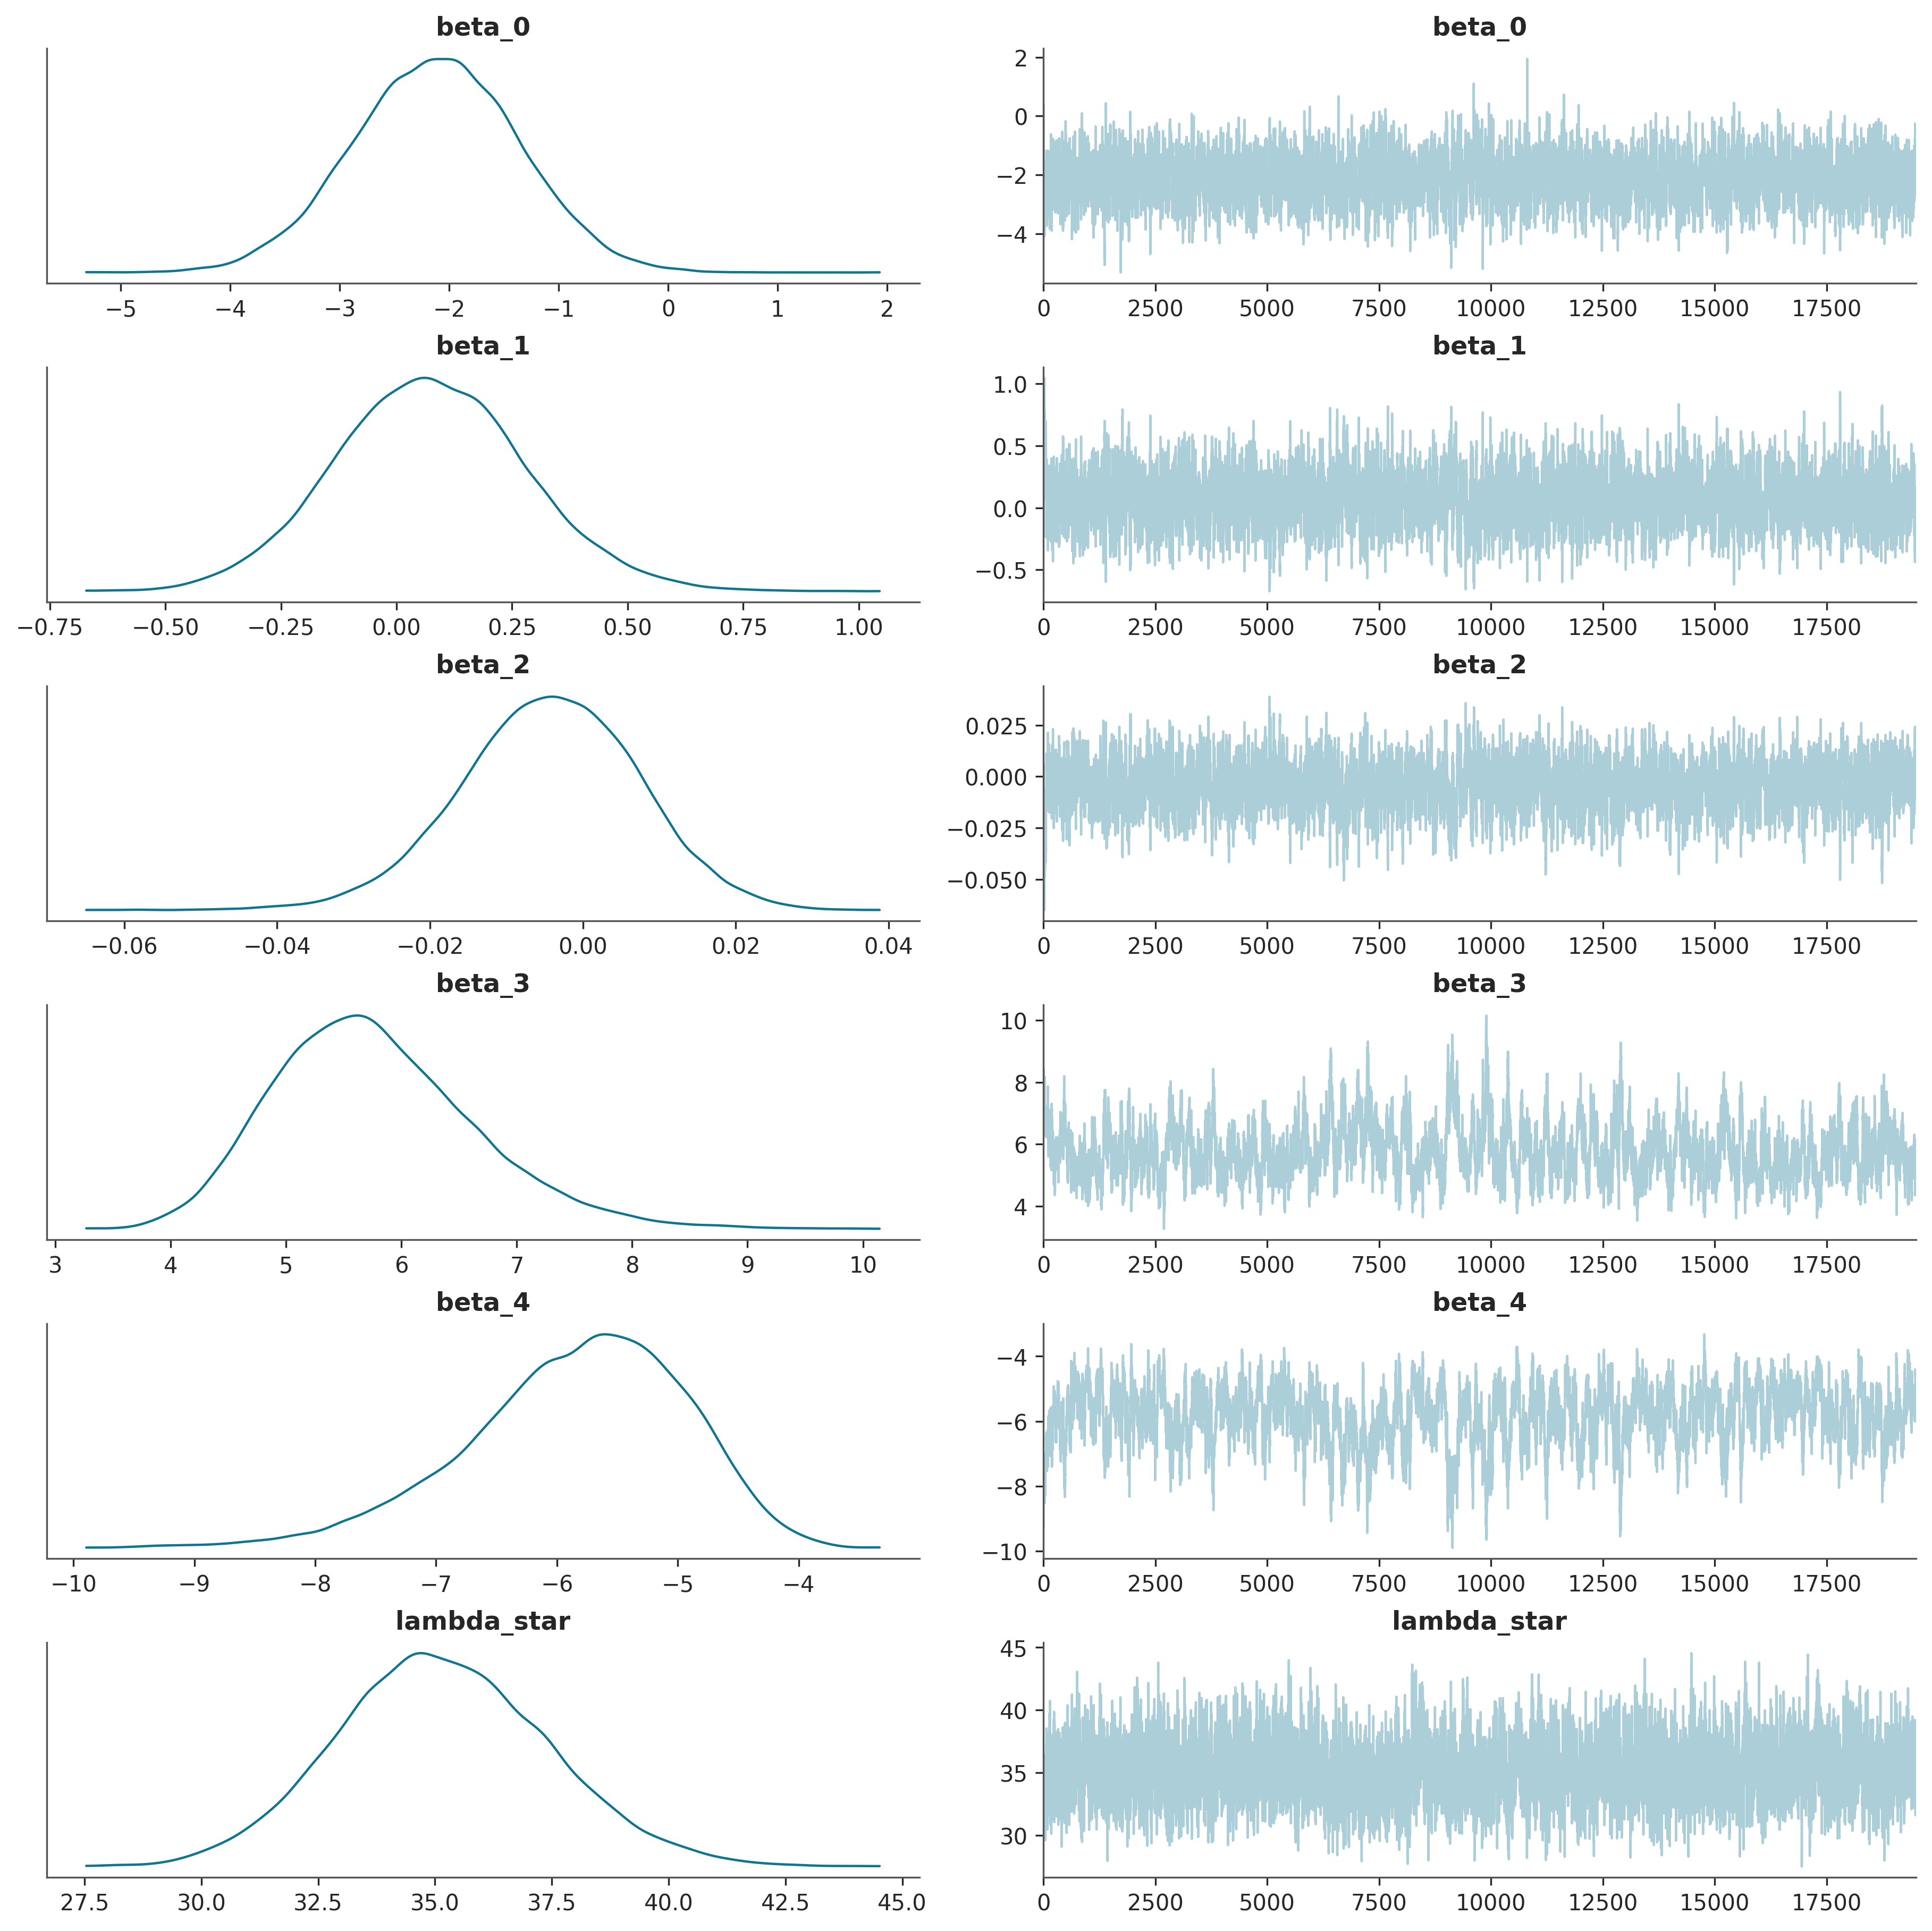

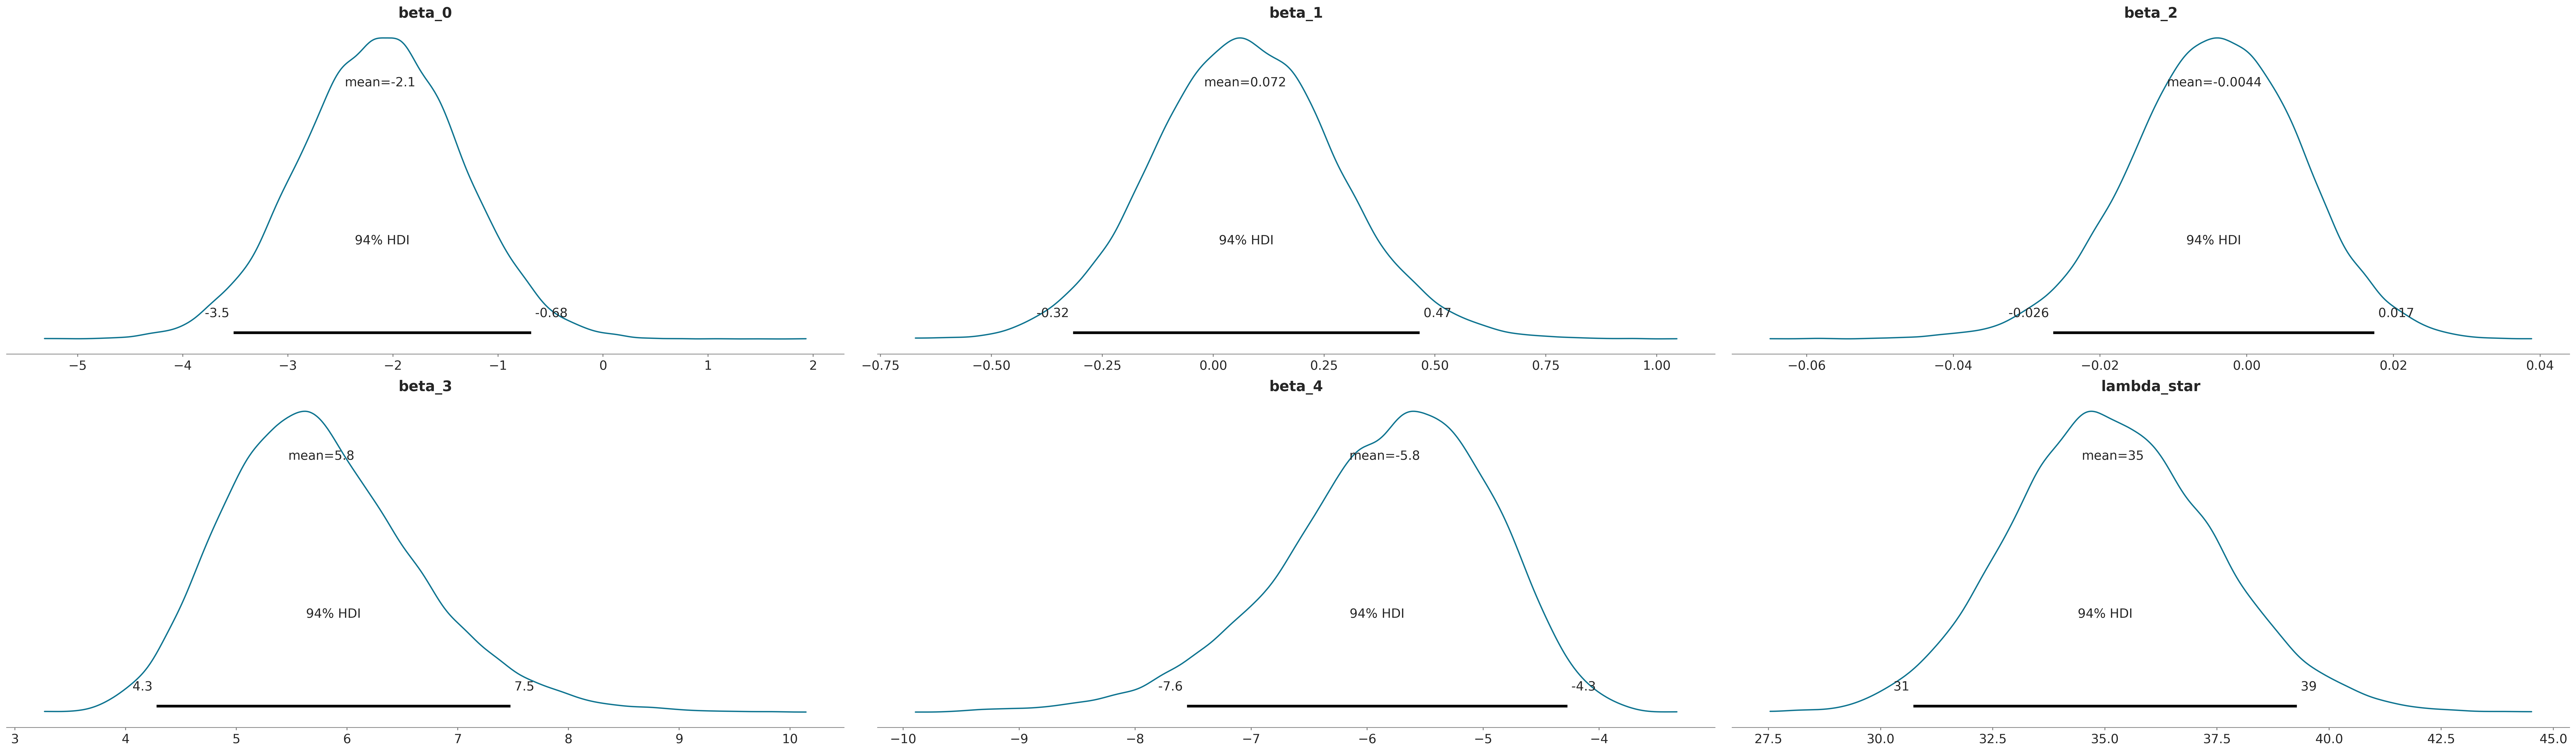

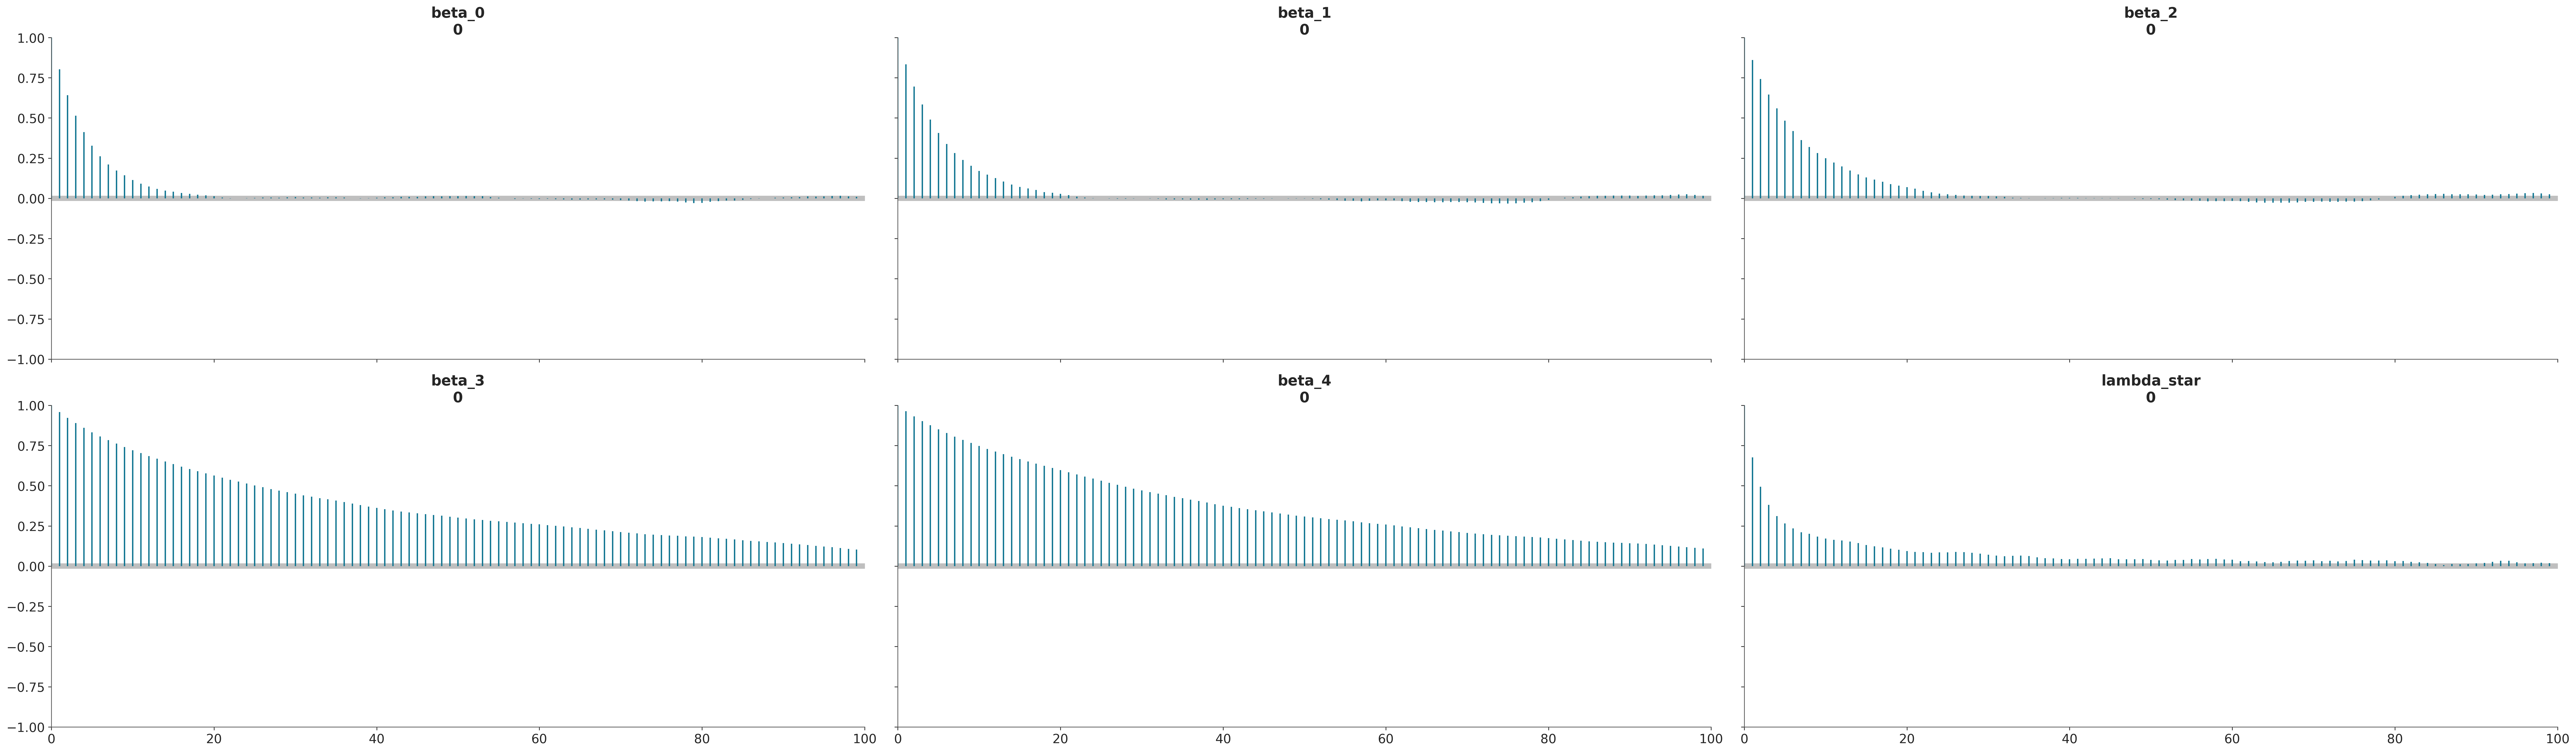

arviz - WARNING - Shape validation failed: input_shape: (1, 19500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_0       -2.121  0.757  -3.517   -0.684      0.016    0.012    2145.0   
beta_1        0.072  0.207  -0.316    0.465      0.005    0.003    1778.0   
beta_2       -0.004  0.012  -0.026    0.017      0.000    0.000    1411.0   
beta_3        5.768  0.872   4.278    7.475      0.056    0.040     261.0   
beta_4       -5.848  0.902  -7.555   -4.274      0.059    0.042     254.0   
lambda_star  35.181  2.272  30.730   39.281      0.067    0.047    1166.0   

             ess_tail  r_hat  
beta_0         4556.0    NaN  
beta_1         3001.0    NaN  
beta_2         2115.0    NaN  
beta_3          433.0    NaN  
beta_4          348.0    NaN  
lambda_star    4045.0    NaN

In [16]:

# --- ArviZによる可視化と解析 ---
az.style.use("arviz-doc")


# トレースプロット
az.plot_trace(idata)
plt.show()

# 事後分布のプロット
az.plot_posterior(idata)
plt.show()

# 自己相関プロット
az.plot_autocorr(idata)
plt.show()

# 統計的な概要情報の表示
summary_df = az.summary(idata)
display(summary_df)

In [17]:
az.plot_pair(idata, var_names=["beta_0", "beta_1", "beta_2", "beta_3", "beta_4"], kind='kde', marginals=True)
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3000)